This notebook addresses unrelated parallel machine scheduling problem with sequence- and machine-dependent setup times. The objective studied is minimizing the completion time of latest job (makespan). 

Each job is associated with a proccesing time, needs to be processed by one of the unrelated parallel machines and preemption is not allowed.  

The scheduling problem can be represented by <em>R</em> | $s_{ijm}$ | $C_{max}$  . This problem is known to be NP-hard. IBM ILOG CPLEX Optimization Studio includes solvers for both Mathematical and Constraint Programming. Constraint Programming is particularly efficient and useful to tackle detailed scheduling problems. By using docplex.cp python package, you can easily formulate and solve scheduling problems in python notebooks. Below is an example formulation with randomly generated sample data to provide a better understanding of the problem and the model.

In [1]:
nbrOfJobs = 10
jobs = [*range(0, nbrOfJobs)] 

In [2]:
nbrOfMachines = 3
machines = [*range(0, nbrOfMachines)] 

In [3]:
#generate a processing time for each job at each machine (randomly)
import random
minProcessingTime=10
maxProcessingTime=40
processingTimes = [[random.randint(minProcessingTime,maxProcessingTime) for j in jobs]  for m in machines] 

In [4]:
#generate sequence dependent setup times between jobs at each machine (randomly)
setup_matrix = [*range(0, nbrOfMachines)] 
for m in machines:
    for j in jobs:
        for j in jobs:
            setup_matrix[m]=[[random.randint(6,15) for j in jobs]for j in jobs]

In [5]:
from docplex.cp.model import *
mdl = CpoModel(name='parallelMachineScheduling_UnrelatedMachines_SequenceDependentSetupTimes') 

In [6]:
# define production processing interval of each job at each machine
processing_itv_vars = [[mdl.interval_var(optional=True, size=processingTimes[m][j], name="interval_job{}_machine{}".format(j,m)) for m in machines] for j in jobs] 
for m in machines:
    for j in jobs:
        print(processing_itv_vars[j][m])

interval_job0_machine0 = intervalVar(optional, size=11)
interval_job1_machine0 = intervalVar(optional, size=37)
interval_job2_machine0 = intervalVar(optional, size=31)
interval_job3_machine0 = intervalVar(optional, size=36)
interval_job4_machine0 = intervalVar(optional, size=18)
interval_job5_machine0 = intervalVar(optional, size=26)
interval_job6_machine0 = intervalVar(optional, size=10)
interval_job7_machine0 = intervalVar(optional, size=37)
interval_job8_machine0 = intervalVar(optional, size=30)
interval_job9_machine0 = intervalVar(optional, size=39)
interval_job0_machine1 = intervalVar(optional, size=27)
interval_job1_machine1 = intervalVar(optional, size=27)
interval_job2_machine1 = intervalVar(optional, size=22)
interval_job3_machine1 = intervalVar(optional, size=26)
interval_job4_machine1 = intervalVar(optional, size=36)
interval_job5_machine1 = intervalVar(optional, size=34)
interval_job6_machine1 = intervalVar(optional, size=31)
interval_job7_machine1 = intervalVar(optional, s

In [7]:
#minimize makespan
objective = mdl.max([mdl.end_of(processing_itv_vars[j][m]) for j in jobs for m in machines])
mdl.add(mdl.minimize(objective)) 

In [8]:
#each job should be assigned to a machine
for j in jobs:
    mdl.add(mdl.sum([mdl.presence_of(processing_itv_vars[j][m]) for m in machines]) == 1)

In [9]:
#No overlap constraint
sequence_vars = [mdl.sequence_var([processing_itv_vars[j][m] for j in jobs], types = [j for j in jobs], name = "sequences_machine{}".format(m)) for m in machines]
for m in machines:
    mdl.add(mdl.no_overlap(sequence_vars[m],setup_matrix[m],is_direct=True))    

In [10]:
msol= mdl.solve(log_output=True)

In [11]:
print("Solution: ")
msol.print_solution()

Solution: 
-------------------------------------------------------------------------------
Model constraints: 13, variables: integer: 0, interval: 30, sequence: 3
Solve status: Optimal, Fail status: SearchHasFailedNormally
Search status: SearchCompleted, stop cause: SearchHasNotBeenStopped
Solve time: 19.88 sec
-------------------------------------------------------------------------------
Objective values: (84,), bounds: (84,), gaps: (0,)
interval_job0_machine0: absent
interval_job0_machine1: absent
interval_job0_machine2: (start=44, end=65, size=21, length=21)
interval_job1_machine0: absent
interval_job1_machine1: absent
interval_job1_machine2: (start=74, end=84, size=10, length=10)
interval_job2_machine0: absent
interval_job2_machine1: absent
interval_job2_machine2: (start=28, end=38, size=10, length=10)
interval_job3_machine0: absent
interval_job3_machine1: (start=58, end=84, size=26, length=26)
interval_job3_machine2: absent
interval_job4_machine0: (start=0, end=18, size=18, lengt

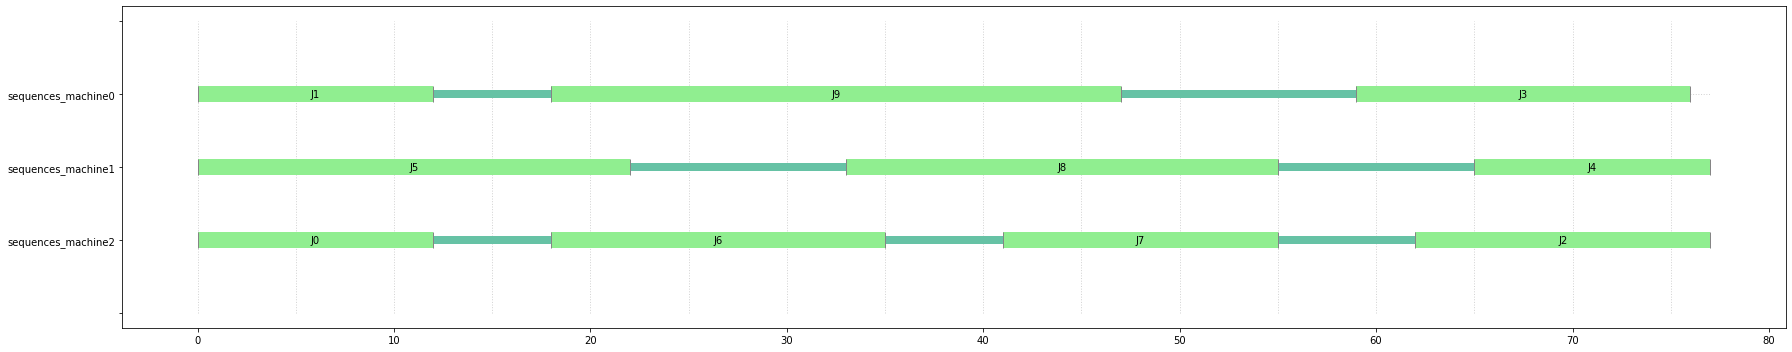

In [18]:
import docplex.cp.utils_visu as visu
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 25, 5

seq = [*range(0, nbrOfMachines)] 
# Build a map to retrieve task id from variable name (for display purpose)
job_id = dict()
for m in machines:
    for j in jobs:
        job_id[processing_itv_vars[j][m].get_name()] = j
    seq[m] = msol.get_var_solution(sequence_vars[m])   
    visu.sequence(name=sequence_vars[m].get_name())
    vs = seq[m].get_value()
    for v in vs:
        nm = v.get_name()
        visu.interval(v, 'lightgreen' , 'J' + str(job_id[nm]))
    for j in range(len(vs) - 1):
        end = vs[j].get_end()
        j1 = job_id[vs[j].get_name()]
        j2 = job_id[vs[j + 1].get_name()]
        visu.transition(end, end + setup_matrix[m][j1][j2])
visu.show()